# Using ESOP to discover the optimal point at which to initiate a lock-down
### Accompanying paper available at https://arxiv.org/abs/2005.11257

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skopt import gp_minimize as gpm
import numpy as np
import time
from utils import Population
from matplotlib import pyplot as plt
import pylab as plb

**Getting started**: we load the generic population file, modify the viral incubation period to 10 days and set the simulations to run for 500 time steps.

**Notation**: We use I0, P0, L0 to denote respectively, the initiation point, period and the level of the lockdown that ESOP is trying to optimize. In this experiment, P0 and L0 have been fixed and ESOP is only asked to find the optimal value of I0

In [3]:
pop = Population.fileInit( "pop_generic" )
pop.INC = 10
N = pop.N
T = 500
P0 = 30
L0 = 5

In [4]:
SIDX_S = 0    # Number of susceptible but non-recovered individuals
SIDX_E = 1    # Number of exposed individuals
SIDX_I = 2    # Number of infectious individuals
SIDX_Q = 3    # Number of quanrantined individuals
SIDX_R = 4    # Number of recovered individuals
SIDX_X = 5    # Number of expired individuals
SIDX_V = 6    # Average virulence of the viral strains in E and I populations
SIDX_EI = 7    # Number of infected individuals
SIDX_D = 8    # Number of individuals infected each day

**Implementation of the ESOP Algorithm**: TODO: put ESOP into a customizable wrapper

In [5]:
# From the normalized parameter being optimized by ESOP, recover the I0 value
def getI0( x ):
    global I0c, I0w, ul, ll
    SVal = int( np.floor( I0c + (x - 0.5) / 0.5 * I0w ) )
    # Make sure that the recovered value is a legal one
    correctedSVal = min( max( SVal, ll ), ul )
    return correctedSVal

# Get a lockdown schedule corresponding to a certain I0 value
def getLKP( I0 ):
    LKP = np.zeros((T,))
    LKP[I0:I0+P0] = L0
    return LKP

# Find out the objective value corresponding to the stats sent as input
# For this experiment, the objective value is simply f_epi since f_eco is
# already decided since the duration of the lock-down is fixed at P0 = 30
def obj( stats ):
    global SIDX_EI
    fEpi = np.max( stats[ SIDX_EI, : ] )
    return fEpi

# Ask the VIPER simulator what does it think will happen if lock-down is
# initiated as specified in the normalized parameter x
def askSimulator( x ):
    global I0c, I0w, evalCount, globalDict, freshMask
    # Before starting a simulation, turn back time to reset everything
    pop.reset()
    # Also seed the RNG so that simulations are replicatable
    np.random.seed(0)
    I0 = getI0( x[0] )
    # Avoid simulating again for previously queried points
    if I0 in globalDict:
        freshMask.append( False )
        return globalDict[I0]
    LKP = getLKP( I0 )
    stats = pop.simulate( T = T, LKP = LKP, minimal = True )
    globalDict[I0] = obj( stats )
    freshMask.append( True )
    evalCount += 1
    return obj( stats )

# Once ESOP is done, find out which parameter, i.e. which value of I0 won!
def getWinner():
    global globalDict
    keys = np.array( list( globalDict.keys() ) )
    vals = np.array( list( globalDict.values() ) )
    winnerIdx = np.argmin( vals )
    winner = keys[ winnerIdx ]
    return winner

**Verifying the Optimality of ESOP**: in the following, we run VIPER simulations with all initiation points in the range \[1, 100\] and calculate the objective value for each simulation so that we may later verify the optimality of the initiation point given by ESOP. Note that ESOP itself requires far fewer (4-12) calls to find the optimal initiation point.

In [6]:
truefEpi = np.zeros((100,))
trueStats = []
for s in range(100):
    tic = time.perf_counter()
    # Before starting a simulation, turn back time to reset everything
    pop.reset()
    # Also seed the RNG so that simulations are replicatable
    np.random.seed(0)
    LKP = getLKP( s )
    stats = pop.simulate( T = T, LKP = LKP, minimal = True )
    truefEpi[s] = obj( stats )
    trueStats.append( stats )
    toc = time.perf_counter()
    # Keep printing stuff so that we do not go mad with anticipation!
    if s % 10 == 0:
        print( toc - tic )

3.8823969999999974
4.69632519999999
4.4546845999999505
4.696469499999978
4.648584699999958
4.727604999999983
4.818080000000009
4.644103400000063
4.460672299999942
4.231053400000064


**Multi-scale Optimization**: ESOP performs Bayesian optimization in a multi-scale manner in several epochs. Initial epochs perform coarse optimization to roughly identify the region with promising objective values. Later epochs zoom into those regions to more and more finely search to obtain points offering highly optimal objective values.

In [7]:
# Initially search in the range [0, 100] for the optimal value of I0
# We represent this range using the center and width of this region
# i.e. as [I0c - I0w, I0c + I0w] where I0c = 50, I0w = 50
I0c = 50
I0w = 50
evalCount = 0
globalDict = {}
freshMask = []
# Upper and lower bounds on legal values of lock-down initiation points
ul = 100
ll = 0

for epoch in range( 6 ):
    print( "epoch = ", epoch )
    res = gpm( askSimulator, [(0.0, 1.0)],  acq_func = "EI", n_calls = 10, n_random_starts = 4, random_state = 0 )
    # Refine the search in the next epoch
    # Choose the best point seen till now as the new center
    I0c = getI0( res.x[0] )
    # Halve the width of the region in which we are searching
    I0w = I0w / 2

epoch =  0
epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5


**Convergence Plots**: The following code is meant to reproduce Fig 3(b) in the accompanying paper.

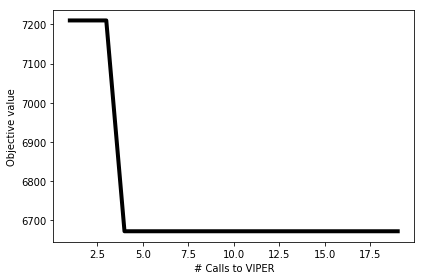

In [8]:
validVals = np.array( list( globalDict.values() ) )
mins = np.minimum.accumulate( validVals )
plt.figure()
plt.plot( np.arange(1, len( validVals ) + 1), mins, color = 'k', linewidth = 4 )
plt.xlabel( "# Calls to VIPER" )
plt.ylabel( "Objective value" )
plt.tight_layout()

Start on day 62, last for 30 days, at level 5.000000


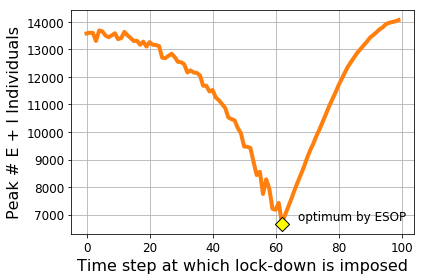

In [9]:
# Find out the suggestion made by ESOP
I0Best = getWinner()
print( "Start on day %d, last for %d days, at level %f" % ( I0Best, P0, L0 ) )

fig = plt.figure()
ax = plt.gca()
plt.grid()
plt.xlabel("Time step at which lock-down is imposed", size = 16)
plt.ylabel("Peak # E + I Individuals", size = 16)
ax.tick_params( axis='both', which='major', labelsize = 12 )
plt.scatter( I0Best, truefEpi[I0Best], color = 'k', facecolor = "yellow", marker = 'D', s = 100, zorder = 5 )
plt.text( 67, 6800, "optimum by ESOP", fontsize = 12 )
plt.plot( truefEpi, color = "#ff7f0e", linewidth = 4 )
plt.tight_layout()

# Final Results

In [10]:
pop.reset()
np.random.seed(0)

LKP = getLKP( I0Best )

(stats, tInfect, tQuarantine, tRecovery, tExpiry) = pop.simulate( T = T, LKP = LKP )

outcome = obj( stats )
print( "%d Infected" % len(tInfect) )
print( "%d Expired" % len(tExpiry) )
print( "Peak %d" % max(stats[SIDX_EI,:]) )
print( "Recovery time %f" % np.mean( tRecovery ) )
print( "Expiry time %f" % np.mean( tExpiry ) )
print( "Quarantine time %f" % np.mean( tQuarantine ) )
print( "%d Quarantined" % len( tQuarantine ) )
print( "Objective acheived is %f" % outcome )

15533 Infected
2224 Expired
Peak 6672
Recovery time 89.929371
Expiry time 28.792266
Quarantine time 18.143396
14847 Quarantined
Objective acheived is 6672.000000


**Outcome of Lock-down suggested by ESOP**: The following code is meant to reproduce Fig 2(d) in the accompanying paper.

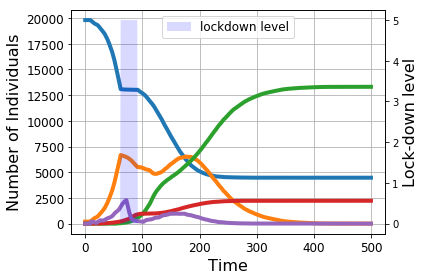

In [11]:
names = [ "S", "E", "I", "Q", "R", "X", "V", "EI", "D" ]
fullnames = [ "Susceptible (S)", "Exposed (E)", "Infectious (I)", "Quarantined (Q)", "Recovered (R)", "Expired (X)", "V", "Exposed + Infectious (E + I)", "Daily" ]
fig, ax = plt.subplots()
plt.grid()
ax2 = ax.twinx()
fillLimit = LKP
fillLimit[0] = fillLimit[-1] = 0
plb.fill( np.arange( T ), fillLimit, facecolor = "blue", label = "lockdown level", alpha = 0.15 )
plt.legend( loc = "upper center", fontsize = 12 )
plt.ylabel("Lock-down level", size = 16)
plt.sca( ax )
for s in [0,7,4,5]:
    ax.plot( stats[s,:], label = fullnames[s], linewidth = 4 )
ax.plot( stats[SIDX_I,:] - stats[SIDX_Q], label = "Non-quaran. Infectious (I - Q)", linewidth = 4 )
plt.xlabel("Time", size = 16)
plt.ylabel("Number of Individuals", size = 16)
ax.tick_params( axis='both', which='major', labelsize = 12 )
plt.tight_layout()

**No Lock-down Outcome**: The following code is meant to reproduce Fig 2(c) in the accompanying paper where no lockdown is imposed at all.

In [12]:
pop.reset()
np.random.seed(0)

LKP = np.zeros((T,))

(stats, tInfect, tQuarantine, tRecovery, tExpiry) = pop.simulate( T = T, LKP = LKP )

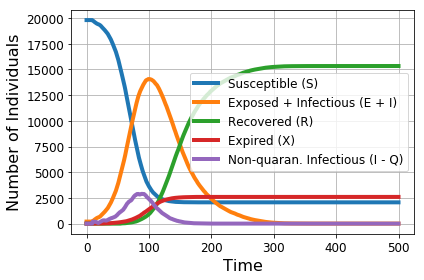

In [13]:
names = [ "S", "E", "I", "Q", "R", "X", "V", "EI", "D" ]
fullnames = [ "Susceptible (S)", "Exposed (E)", "Infectious (I)", "Quarantined (Q)", "Recovered (R)", "Expired (X)", "V", "Exposed + Infectious (E + I)", "Daily" ]
fig, ax = plt.subplots()
plt.grid()
for s in [0,7,4,5]:
    ax.plot( stats[s,:], label = fullnames[s], linewidth = 4 )
ax.plot( stats[SIDX_I,:] - stats[SIDX_Q], label = "Non-quaran. Infectious (I - Q)", linewidth = 4 )
plt.xlabel("Time", size = 16)
plt.ylabel("Number of Individuals", size = 16)
ax.tick_params( axis='both', which='major', labelsize = 12 )
plt.legend( fontsize = 12 )
plt.tight_layout()